<a href="https://colab.research.google.com/github/dustoff06/Trout/blob/main/Complete_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
!pip install openpyxl
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

## Read Data

In [2]:
file_path = "/content/drive/MyDrive/RainbowTrout_Growth_Data.xlsx"
env_data = pd.read_excel(file_path, sheet_name=1)
fish_data = pd.read_excel(file_path, sheet_name=2)

## Create Date/Time Variables

In [3]:
fish_data['ReleaseDate'] = pd.to_datetime(fish_data['Release Trip'])
fish_data['RecoveryDate'] = pd.to_datetime(fish_data['Recovery Trip'])

# Extract month and year
fish_data['ReleaseMonth'] = fish_data['ReleaseDate'].dt.month
fish_data['ReleaseYear'] = fish_data['ReleaseDate'].dt.year
fish_data['RecoveryMonth'] = fish_data['RecoveryDate'].dt.month
fish_data['RecoveryYear'] = fish_data['RecoveryDate'].dt.year
#NOTE:  Time at Large and Days Between were identical!

## Drop Unneeded Variables

In [4]:
fish_data = fish_data.drop(columns=['Release River Mile', 'Recovery River Mile',
                                    'Weight at Release', 'Weight at Recapture','Length_Growth',
                                    'ReleaseDate','RecoveryDate', 'Weight_Growth'])
fish_data = fish_data.rename(columns={
    'Forklength at Release': 'L1',
    'Forklength at Recapture': 'L2'
})
fish_data.head()

,Release Trip,Recovery Trip,Time at Large,L1,L2,ReleaseMonth,ReleaseYear,RecoveryMonth,RecoveryYear
0,2012-04-19,2012-07-05,77,337.0,334,4,2012,7,2012
1,2012-04-19,2012-07-05,77,330.0,329,4,2012,7,2012
2,2012-04-19,2012-07-05,77,344.0,348,4,2012,7,2012
3,2012-04-19,2012-07-05,77,284.0,287,4,2012,7,2012
4,2012-04-19,2012-07-05,77,93.0,119,4,2012,7,2012


## Convert to Dummies

In [5]:
# Get modal values before dummy creation
release_month_mode = fish_data['ReleaseMonth'].mode()[0]
release_year_mode = fish_data['ReleaseYear'].mode()[0]
recovery_month_mode = fish_data['RecoveryMonth'].mode()[0]
recovery_year_mode = fish_data['RecoveryYear'].mode()[0]

# Create dummies
fish_data = pd.get_dummies(fish_data,
                           columns=['ReleaseMonth', 'ReleaseYear', 'RecoveryMonth', 'RecoveryYear'],
                           drop_first=False)

# Drop dummy columns corresponding to modes
fish_data.drop([
    f'ReleaseMonth_{release_month_mode}',
    f'ReleaseYear_{release_year_mode}',
    f'RecoveryMonth_{recovery_month_mode}',
    f'RecoveryYear_{recovery_year_mode}'
], axis=1, inplace=True)

# Convert all dummy columns to integers (0/1)
dummy_cols = [col for col in fish_data.columns if
              col.startswith('ReleaseMonth_') or
              col.startswith('ReleaseYear_') or
              col.startswith('RecoveryMonth_') or
              col.startswith('RecoveryYear_')]

fish_data[dummy_cols] = fish_data[dummy_cols].astype(int)

fish_data.head()

,Release Trip,Recovery Trip,Time at Large,L1,L2,ReleaseMonth_1,ReleaseMonth_2,ReleaseMonth_3,ReleaseMonth_4,ReleaseMonth_6,...,RecoveryMonth_12,RecoveryYear_2012,RecoveryYear_2013,RecoveryYear_2014,RecoveryYear_2015,RecoveryYear_2017,RecoveryYear_2018,RecoveryYear_2019,RecoveryYear_2020,RecoveryYear_2021
0,2012-04-19,2012-07-05,77,337.0,334,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,2012-04-19,2012-07-05,77,330.0,329,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,2012-04-19,2012-07-05,77,344.0,348,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,2012-04-19,2012-07-05,77,284.0,287,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,2012-04-19,2012-07-05,77,93.0,119,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


## Merge with Environmental Variables

In [6]:
# Select environmental variables to merge with fish data
env_vars = ["Discharge", "Water Temperature", "Solar Insolation",
    "Soluble Reactive Phosphorous Concentration"]

# Process all data in one go
def parse_env_dates(interval):
    start_part, end_part = interval.split('-')
    start_date = pd.to_datetime(start_part + '-01', format='%b%y-%d')
    end_date = pd.to_datetime(end_part + '-01', format='%b%y-%d') + relativedelta(months=1, days=-1)
    return start_date, end_date

# Convert dates efficiently
env_data[['start_date', 'end_date']] = env_data['Trip Interval'].apply(lambda x: pd.Series(parse_env_dates(x)))
fish_data['Release Trip'] = pd.to_datetime(fish_data['Release Trip'])
fish_data['Recovery Trip'] = pd.to_datetime(fish_data['Recovery Trip'])

# Initialize environmental variable columns
fish_data[env_vars] = None

def get_weighted_env_values(release, recovery, env_data, env_vars):
    # Try exact interval match first
    exact_match = env_data[(env_data['start_date'] <= release) & (env_data['end_date'] >= recovery)]
    if len(exact_match) == 1:
        return exact_match[env_vars].iloc[0].values

    # Find overlapping intervals
    overlaps = env_data[(env_data['end_date'] >= release) & (env_data['start_date'] <= recovery)]
    if not len(overlaps):
        return [None] * len(env_vars)

    # Calculate weighted average
    total_days = (recovery - release).days + 1

    # Use a list to store intermediate results instead of numpy array
    weighted_sum = [0.0] * len(env_vars)

    for _, env_row in overlaps.iterrows():
        overlap_start = max(release, env_row['start_date'])
        overlap_end = min(recovery, env_row['end_date'])
        weight = ((overlap_end - overlap_start).days + 1) / total_days

        # Convert values to float and handle any non-numeric values
        for i, var in enumerate(env_vars):
            try:
                value = float(env_row[var])
                weighted_sum[i] += weight * value
            except (ValueError, TypeError):
                # Skip non-numeric values
                pass

    return weighted_sum

# Apply the function to all rows
for idx, row in fish_data.iterrows():
    fish_data.loc[idx, env_vars] = get_weighted_env_values(
        row['Release Trip'], row['Recovery Trip'], env_data, env_vars
    )

# Verification
matched_count = fish_data[env_vars[0]].notna().sum()
print(f"Records with matches: {matched_count}/{len(fish_data)}")

Records with matches: 9798/9798


## Look at Data

In [7]:
fish_data.head()

,Release Trip,Recovery Trip,Time at Large,L1,L2,ReleaseMonth_1,ReleaseMonth_2,ReleaseMonth_3,ReleaseMonth_4,ReleaseMonth_6,...,RecoveryYear_2015,RecoveryYear_2017,RecoveryYear_2018,RecoveryYear_2019,RecoveryYear_2020,RecoveryYear_2021,Discharge,Water Temperature,Solar Insolation,Soluble Reactive Phosphorous Concentration
0,2012-04-19,2012-07-05,77,337.0,334,0,0,0,1,0,...,0,0,0,0,0,0,10.46,9.8,54.28,0.012938
1,2012-04-19,2012-07-05,77,330.0,329,0,0,0,1,0,...,0,0,0,0,0,0,10.46,9.8,54.28,0.012938
2,2012-04-19,2012-07-05,77,344.0,348,0,0,0,1,0,...,0,0,0,0,0,0,10.46,9.8,54.28,0.012938
3,2012-04-19,2012-07-05,77,284.0,287,0,0,0,1,0,...,0,0,0,0,0,0,10.46,9.8,54.28,0.012938
4,2012-04-19,2012-07-05,77,93.0,119,0,0,0,1,0,...,0,0,0,0,0,0,10.46,9.8,54.28,0.012938


## Drop Variables Used Solely for Merge

In [8]:
fish_data = fish_data.drop(columns=['Release Trip', 'Recovery Trip'])

## Verify Structure

In [9]:
# Convert all object columns to numeric
for col in fish_data.select_dtypes(include='object').columns:
    fish_data[col] = pd.to_numeric(fish_data[col], errors='coerce')


## Describe

## Identify Extreme Outliers


In [10]:
#Clean Copy of DF
fish_model_data = fish_data.copy()

# Calculate Q1, Q3, and IQR
Q1 = fish_model_data['L2'].quantile(0.25)
Q3 = fish_model_data['L2'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds (using 3x IQR)
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Identify outliers
outliers = fish_model_data[(fish_model_data['L2'] < lower_bound) |
                           (fish_model_data['L2'] > upper_bound)]

# Display outliers
print(f"Outliers detected: {len(outliers)}")
print(outliers[['L2']])

Outliers detected: 0
Empty DataFrame
Columns: [L2]
Index: []


In [11]:
fish_data.describe()

,Time at Large,L1,L2,ReleaseMonth_1,ReleaseMonth_2,ReleaseMonth_3,ReleaseMonth_4,ReleaseMonth_6,ReleaseMonth_7,ReleaseMonth_10,...,RecoveryYear_2015,RecoveryYear_2017,RecoveryYear_2018,RecoveryYear_2019,RecoveryYear_2020,RecoveryYear_2021,Discharge,Water Temperature,Solar Insolation,Soluble Reactive Phosphorous Concentration
count,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,...,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000
mean,243.473158,187.260247,218.919882,0.167279,0.022454,0.023474,0.142784,0.142172,0.015820,0.166258,...,0.124617,0.121862,0.121760,0.121249,0.088181,0.097775,15.940543,14.274255,43.324412,0.006388
std,285.592323,87.532780,85.793041,0.373244,0.148161,0.151412,0.349871,0.349244,0.124783,0.372331,...,0.330301,0.327143,0.327025,0.326433,0.283573,0.297025,4.181992,3.626447,19.296020,0.002851
min,28.000000,70.000000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.430000,7.850000,10.090000,0.001199
25%,74.000000,106.000000,136.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.410000,11.660000,27.938780,0.004367
50%,130.500000,163.000000,230.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.156089,14.459368,46.774825,0.005413
75%,288.000000,267.000000,293.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.276148,16.495600,54.239328,0.008359
max,2256.000000,457.000000,472.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,31.283019,25.482075,89.899779,0.017385


## Boxplot of Dependent Variable

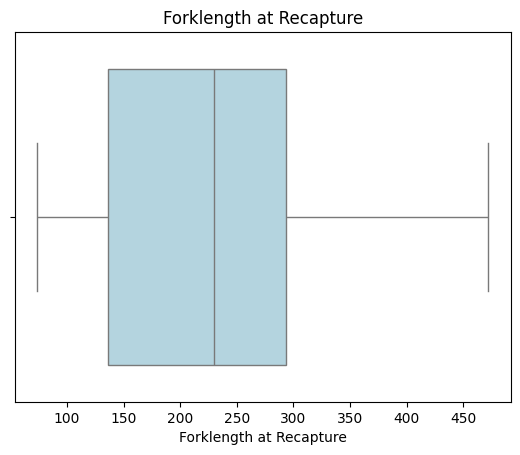

In [12]:
sns.boxplot(x=fish_model_data['L2'], color='lightblue')
plt.xlabel('Forklength at Recapture')
plt.title('Forklength at Recapture')
plt.show()

## Correlation Analysis

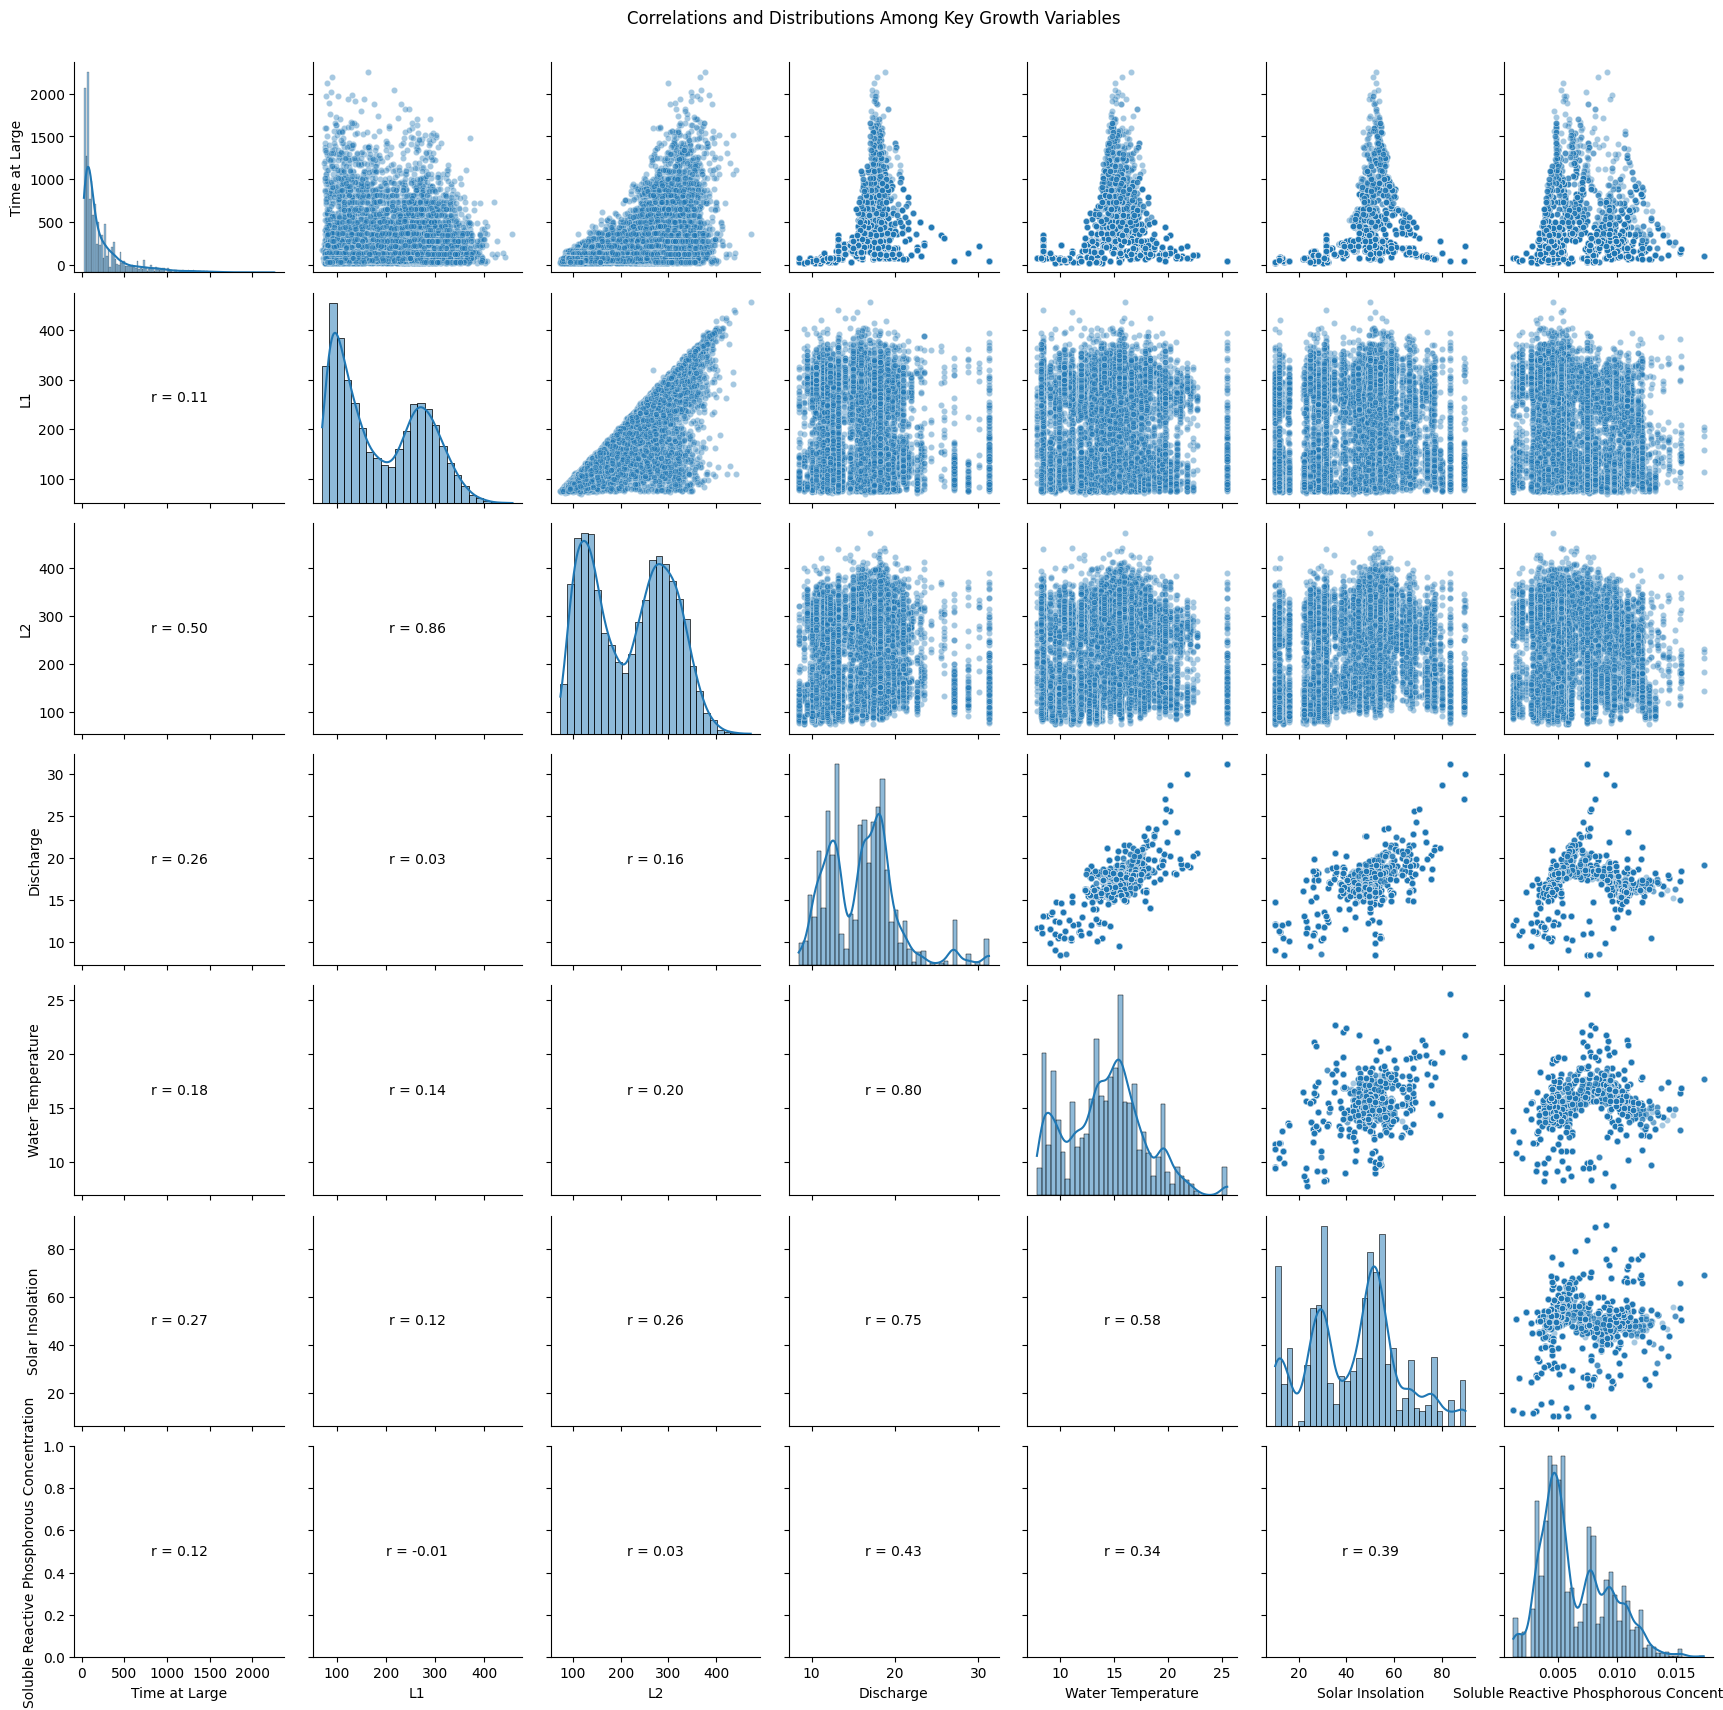

In [13]:
from scipy.stats import pearsonr
from matplotlib.patches import Ellipse

# Subset of only continuous (non-dummy) variables
cont_vars = [
    'Time at Large', 'L1', 'L2',
    'Discharge', 'Water Temperature', 'Solar Insolation',
    'Soluble Reactive Phosphorous Concentration'
]

df = fish_data[cont_vars].dropna()

# Custom PairGrid
g = sns.PairGrid(df, diag_sharey=False)

# Lower: correlation coefficients
def corr_func(x, y, **kwargs):
    r, _ = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(f'r = {r:.2f}', xy=(0.5, 0.5), xycoords=ax.transAxes,
                ha='center', va='center', fontsize=10)

# Upper: scatterplots (could sub with kde or box-like ellipses)
def scatter_func(x, y, **kwargs):
    ax = plt.gca()
    sns.scatterplot(x=x, y=y, alpha=0.4, s=20, ax=ax)

# Diagonal: histograms
g.map_lower(corr_func)
g.map_diag(sns.histplot, kde=True)
g.map_upper(scatter_func)

# Adjust layout
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Correlations and Distributions Among Key Growth Variables')
plt.show()


## Create Clean Dataset and Save

In [14]:
# Export the processed data
fish_model_data = fish_data.copy()
fish_model_data.to_csv('fish_model_data.csv', index=False)
print("Data exported successfully to 'fish_model_data.csv'")

Data exported successfully to 'fish_model_data.csv'


# Metrics Function

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def get_model_metrics(y_true, y_pred, k_params=None, model_name="Model"):
    """
    Compute common regression metrics including AIC, AICC, BIC.

    Parameters:
    - y_true: array-like of true values
    - y_pred: array-like of predicted values
    - k_params: int, number of predictors (including intercept) [optional]
    - model_name: str, name to label the output

    Returns:
    - DataFrame row with metrics
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    n = len(y_true)
    k = k_params if k_params is not None else 1  # default to intercept-only

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Info criteria (use classical formulas here)
    aic = n * np.log(mse) + 2 * k
    aicc = aic + (2 * k * (k + 1)) / (n - k - 1) if (n - k - 1) > 0 else np.nan
    bic = n * np.log(mse) + k * np.log(n)

    metrics = {
        "RMSE": round(rmse, 3),
        "MAE": round(mae, 3),
        "R2": round(r2, 3),
        "AIC": round(aic, 3),
        "AICC": round(aicc, 3),
        "BIC": round(bic, 3)
    }

    return pd.DataFrame([metrics], index=[model_name])


# Train / Test Split

In [16]:
from sklearn.model_selection import train_test_split
X = fish_model_data.drop(columns=["L2"])
y = fish_model_data["L2"]  # Set dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Print dataset sizes

valid_indices=X_test.index
test_indices=X_test.index

y_test= fish_model_data.loc[valid_indices, "L2"]
y_true=y_test

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")




Training set size: 6858
Testing set size: 2940


# Bayesian OLS Model

In [17]:
import pymc as pm
import arviz as az

# Convert data to numeric once and handle missing values properly
X_train_numeric = X_train.astype(float)
y_train_numeric = y_train.astype(float)

# Add constant efficiently using numpy instead of statsmodels
X_train_np = np.column_stack((np.ones(len(X_train_numeric)), X_train_numeric.values))
X_test_np = np.column_stack((np.ones(len(X_test)), X_test.astype(float).values))

# Get feature names for later reference
feature_names = ['intercept'] + X_train.columns.tolist()

# Use with to properly manage resources
with pm.Model() as bayesian_ols:
    # Use more efficient parameterization - sparse priors often sample better
    beta = pm.Normal("beta", mu=0, sigma=5, shape=X_train_np.shape[1])

    # Use log parameterization for sigma which often improves sampling
    log_sigma = pm.LogNormal("log_sigma", mu=0, sigma=1)
    sigma = pm.Deterministic("sigma", pm.math.exp(log_sigma))

    # Vectorized operations using tensor math
    mu = pm.math.dot(X_train_np, beta)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train_numeric.values)

    # Sample with optimized parameters
    trace = pm.sample(
        draws=2000,
        tune=1000,
        cores=2,  # Use multiple cores for parallel sampling
        chains=2,  # Multiple chains for better convergence assessment
        return_inferencedata=True,
        target_accept=0.95
    )

Output()

## Posterior Means

In [18]:
# Extract posterior summaries in a more efficient way
def summarize_bayesian_model(trace, feature_names, hdi_prob=0.94):
    # Extract all summary statistics at once
    beta_means = trace.posterior['beta'].mean(dim=("chain", "draw")).values
    beta_medians = trace.posterior['beta'].median(dim=("chain", "draw")).values

    # Get HDI in one call
    hdi_beta = az.hdi(trace, var_names=['beta'], hdi_prob=hdi_prob)['beta']

    # Handle different HDI dimension naming conventions
    try:
        hdi_lower = hdi_beta.sel(hdi="lower").values
        hdi_upper = hdi_beta.sel(hdi="upper").values
    except KeyError:
        # Fall back to positional indexing if named dimensions aren't available
        hdi_lower = hdi_beta.isel(hdi=0).values
        hdi_upper = hdi_beta.isel(hdi=1).values

    # Create summary dataframe
    summary_df = pd.DataFrame({
        "Feature": feature_names,
        "Mean": beta_means,
        "Median": beta_medians,
        "HDI Lower": hdi_lower,
        "HDI Upper": hdi_upper
    })

    # Add column indicating if the credible interval excludes zero
    summary_df["Significant"] = ~((summary_df["HDI Lower"] <= 0) & (summary_df["HDI Upper"] >= 0))

    # Format and sort
    return summary_df.round(4).sort_values(by="Mean", key=abs, ascending=False).reset_index(drop=True)

# Use the function with your data
feature_names = ['intercept'] + X_train.columns.tolist()
summary_df = summarize_bayesian_model(trace, feature_names)

# Display the results
summary_df

,Feature,Mean,Median,HDI Lower,HDI Upper,Significant
0,intercept,25.5379,25.5604,21.4912,30.0215,True
1,ReleaseYear_2012,-17.6171,-17.6161,-22.0782,-13.3107,True
2,ReleaseYear_2013,-14.8008,-14.7908,-18.2438,-11.7529,True
3,RecoveryYear_2019,13.3284,13.2836,10.0180,16.8757,True
4,ReleaseYear_2019,-12.4196,-12.4097,-15.8756,-8.9868,True
5,RecoveryYear_2020,10.9332,10.9412,7.3240,14.6247,True
6,RecoveryYear_2013,10.9081,10.8837,6.8133,15.0458,True
7,ReleaseMonth_7,9.7659,9.7324,4.5821,14.5136,True
8,ReleaseMonth_3,9.5927,9.6108,5.5403,13.5746,True
9,ReleaseMonth_4,8.6749,8.6712,6.3154,11.2136,True


## Summary of Posterior

array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n3'}>],
       [<Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n5'}>,
        <Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n7'}>],
       [<Axes: title={'center': 'beta\n8'}>,
        <Axes: title={'center': 'beta\n9'}>,
        <Axes: title={'center': 'beta\n10'}>,
        <Axes: title={'center': 'beta\n11'}>],
       [<Axes: title={'center': 'beta\n12'}>,
        <Axes: title={'center': 'beta\n13'}>,
        <Axes: title={'center': 'beta\n14'}>,
        <Axes: title={'center': 'beta\n15'}>],
       [<Axes: title={'center': 'beta\n16'}>,
        <Axes: title={'center': 'beta\n17'}>,
        <Axes: title={'center': 'beta\n18'}>,
        <Axes: title={'center': 'beta\n19'}>],
       [<Axes: title={'center': 'beta\n20'}>,
        <Axes: title={'center': 'beta\n

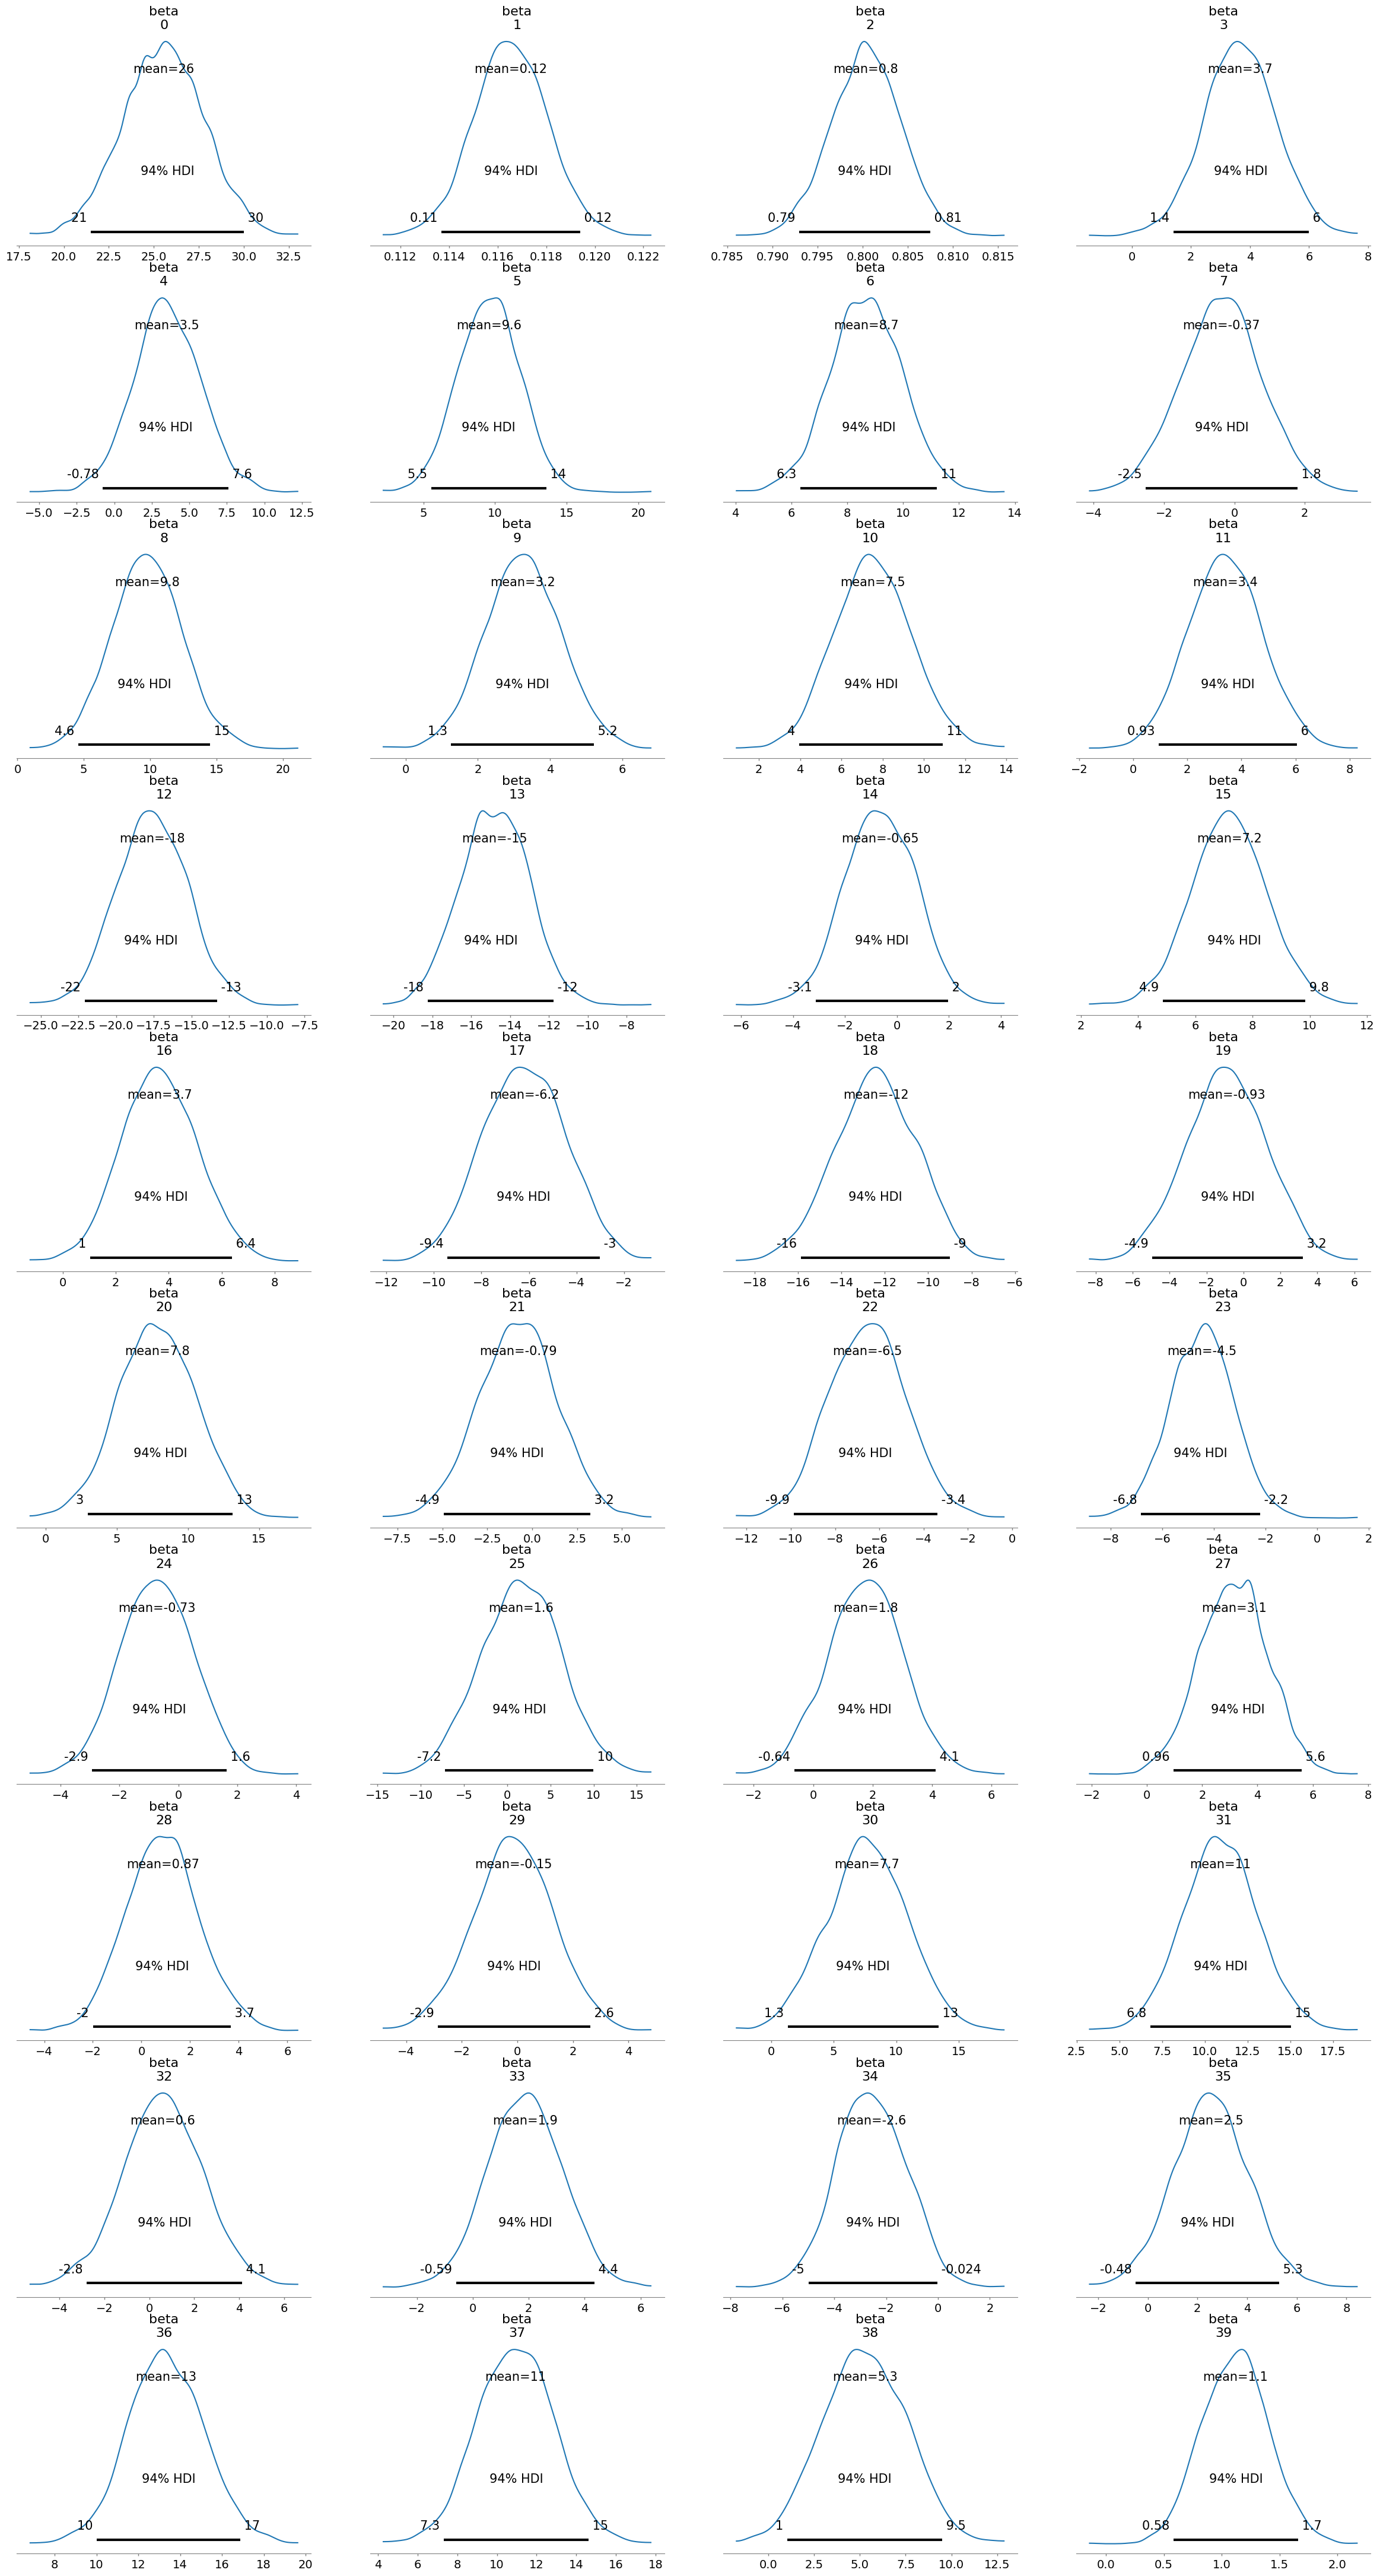

In [19]:
# Include log_sigma to diagnose sampling
az.summary(trace, var_names=["beta", "log_sigma", "sigma"])


# Posterior plot
az.plot_posterior(trace, var_names=["beta", "sigma"])


## Evaluation of $\hat{r}$

In [20]:
az.rhat(trace).to_dataframe().describe()

,beta,log_sigma,sigma
count,43.000000,4.300000e+01,4.300000e+01
mean,1.000839,1.000085e+00,1.000075e+00
std,0.000796,6.740173e-16,2.246724e-16
min,0.999758,1.000085e+00,1.000075e+00
25%,1.000192,1.000085e+00,1.000075e+00
50%,1.000766,1.000085e+00,1.000075e+00
75%,1.001275,1.000085e+00,1.000075e+00
max,1.003572,1.000085e+00,1.000075e+00


## Evaluation of ESS

In [21]:
az.ess(trace).to_dataframe().describe()

,beta,log_sigma,sigma
count,43.000000,4.300000e+01,4.300000e+01
mean,2633.419806,6.770629e+03,6.770629e+03
std,1173.141783,9.202583e-13,9.202583e-13
min,1407.683339,6.770629e+03,6.770629e+03
25%,1824.896875,6.770629e+03,6.770629e+03
50%,2247.322828,6.770629e+03,6.770629e+03
75%,3043.609872,6.770629e+03,6.770629e+03
max,6171.764870,6.770629e+03,6.770629e+03


## Predictions

In [22]:
with bayesian_ols:
    posterior_pred = pm.sample_posterior_predictive(trace, var_names=["y_obs"], predictions=True)
# Extract posterior draws
posterior_betas = trace.posterior['beta'].stack(draws=("chain", "draw")).values
posterior_sigma = trace.posterior['sigma'].stack(draws=("chain", "draw")).values

# Generate predictions for each posterior sample
posterior_predictions = X_test_np @ posterior_betas  # Shape: [n_test, n_draws]

L2_pred_ols = posterior_predictions.mean(axis=1)

Output()

## Metrics

In [23]:
highlight_df = pd.DataFrame(columns=['RMSE', 'MAE', 'R2', 'AIC', 'AICC', 'BIC'])
highlight_df = pd.concat([
    highlight_df,
    get_model_metrics(y_true, L2_pred_ols, k_params=X_test_np.shape[1], model_name="Bayesian OLS")
])
highlight_df

,RMSE,MAE,R2,AIC,AICC,BIC
Bayesian OLS,24.432,16.815,0.92,18877.947,18879.254,19135.352


# ML Model Libraries

In [25]:
# Machine Learning and Model Training

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Advanced Machine Learning Frameworks
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
import tensorflow as tf
import random


# Optimization
from scipy.optimize import minimize

# TensorFlow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

# Tree Models + Predictions + Metrics

In [27]:
# Initialize a dictionary to store predictions
model_predictions = {}

# Define models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, bootstrap=True, max_depth=10, random_state=42),
    "XGBoost": xgb.XGBRegressor(colsample_bytree=0.7, subsample=0.9, max_depth=10, n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, colsample_bytree=0.9, max_depth=10, subsample=0.7, random_state=42, verbosity=-1)
}

# Evaluate each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Save prediction under standardized variable name
    var_name = f"L2_pred_{model_name.lower().replace(' ', '')}"  # e.g., L2_pred_randomforest
    model_predictions[var_name] = y_pred

    # Calculate number of parameters (features + intercept)
    k_params = X_test.shape[1] + 1

    # Compute and append metrics
    metrics_df = get_model_metrics(y_test, y_pred, k_params=k_params, model_name=model_name)
    highlight_df = pd.concat([highlight_df, metrics_df])

# Optional: unpack to globals if needed for plotting (not required if you use model_predictions dictionary)
L2_pred_randomforest = model_predictions['L2_pred_randomforest']
L2_pred_xgboost = model_predictions['L2_pred_xgboost']
L2_pred_lightgbm = model_predictions['L2_pred_lightgbm']

highlight_df


,RMSE,MAE,R2,AIC,AICC,BIC
Bayesian OLS,24.432,16.815,0.920,18877.947,18879.254,19135.352
Random Forest,17.028,11.140,0.961,16754.876,16756.183,17012.281
XGBoost,18.508,12.211,0.954,17244.966,17246.273,17502.371
LightGBM,16.182,10.649,0.965,16455.149,16456.456,16712.554


# Neural Network

## NN Estimation

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,017 (211.00 KB)

 Trainable params: 53,121 (207.50 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.60477, saving model to best_model.keras
172/172 - 4s - 25ms/step - loss: 0.9481 - mae: 0.5690 - val_loss: 0.6048 - val_mae: 0.4078 - learning_rate: 1.0000e-03
Epoch 2/200

Epoch 2: val_loss improved from 0.60477 to 0.45927, saving model to best_model.keras
172/172 - 1s - 5ms/step - loss: 0.6478 - mae: 0.4073 - val_loss: 0.4593 - val_mae: 0.2298 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: val_loss improved from 0.45927 to 0.41878, saving model to best_model.keras
172/172 - 1s - 8ms/step - loss: 0.5590 - mae: 0.3452 - val_loss: 0.4188 - val_mae: 0.1645 - learning_rate: 1.0000e-03
Epoch 4/200

Epoch 4: val_loss improved from 0.41878 to 0.39980, saving model to best_model.keras
172/172 - 1s - 9ms/step - loss: 0.5159 - mae: 0.3170 - val_loss: 0.3998 - val_mae: 0.1578 - learning_rate: 1.0000e-03
Epoch 5/200

Epoch 5: val_loss improved from 0.39980 to 0.38247, saving model to best_model.keras
172/172 - 1s - 6ms/step - loss: 0.4734 - 

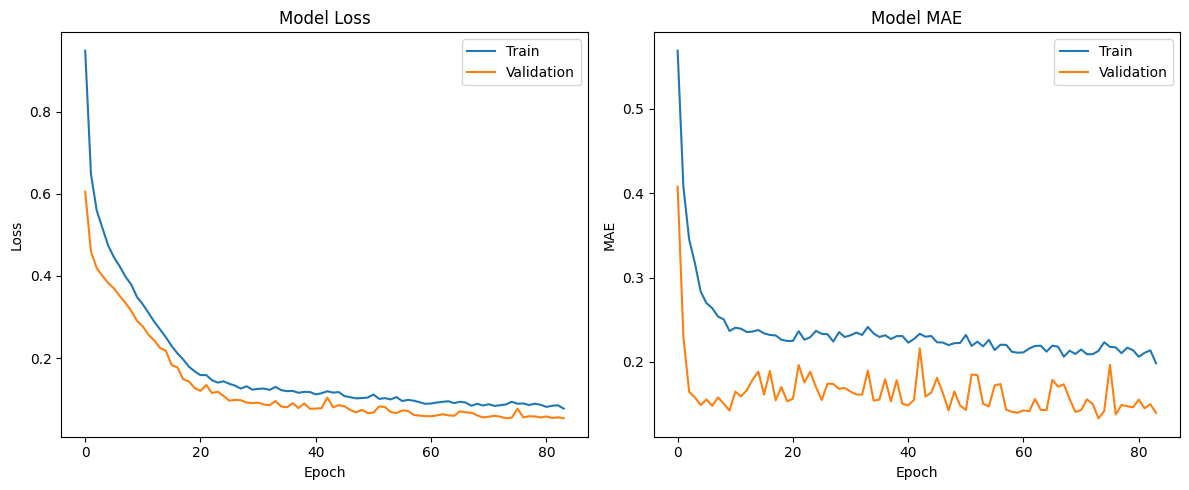

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Mean Squared Error (MSE): 283.8034
Test Mean Absolute Error (MAE): 11.1076


In [28]:

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Save in Keras format
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


# Create the scaler
scaler = StandardScaler()


# Identify non-dummy (continuous) columns — you can do this manually or use dtype
non_dummy_cols = [
    'Time at Large',
    'Discharge', 'Water Temperature', 'Solar Insolation',
    'Soluble Reactive Phosphorous Concentration', 'L1']

# Scale only those columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[non_dummy_cols] = scaler.fit_transform(X_train[non_dummy_cols])
X_test_scaled[non_dummy_cols] = scaler.transform(X_test[non_dummy_cols])

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# Define the neural network architecture
model = Sequential()

# Input layer with batch normalization and leaky ReLU
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

# First hidden layer
model.add(Dense(128, kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

# Second hidden layer
model.add(Dense(64, kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))  # Output layer for regression (no activation function)

# Custom learning rate for optimizer
custom_optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=custom_optimizer, loss='mean_squared_error', metrics=['mae'])

# Print model summary
model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Train the model with callbacks
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=200,  # Increased max epochs (early stopping will prevent overfitting)
    batch_size=32,  # Smaller batch size for better generalization
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=2
)

# Visualize training history
plt.figure(figsize=(12, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation mean absolute error
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

y_pred_scaled = model.predict(X_test_scaled).ravel()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Compare to original (unscaled) test targets
test_loss = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print(f"Test Mean Squared Error (MSE): {test_loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {test_mae:.4f}")

## NN Predictions

In [29]:

# Load and predict
model = load_model('best_model.keras')
y_pred = model.predict(X_test_scaled).flatten()
L2_pred_nn = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## NN Metrics

In [30]:
# Determine k_params based on model attributes
if hasattr(model, 'count_params'):
    k_params = model.count_params()
elif hasattr(model, 'n_features_in_'):
    k_params = model.n_features_in_
else:
    k_params = 8  # fallback if necessary

# Generate metrics using the reusable function
nn_metrics = get_model_metrics(y_test, L2_pred_nn, k_params=k_params, model_name="NN")

# Append to comparison table
highlight_df = pd.concat([highlight_df, nn_metrics])

# Display result
highlight_df


,RMSE,MAE,R2,AIC,AICC,BIC
Bayesian OLS,24.432,16.815,0.920,18877.947,18879.254,19135.352
Random Forest,17.028,11.140,0.961,16754.876,16756.183,17012.281
XGBoost,18.508,12.211,0.954,17244.966,17246.273,17502.371
LightGBM,16.182,10.649,0.965,16455.149,16456.456,16712.554
NN,16.846,11.108,0.962,124639.948,NaN,447994.615


# SVR

## SVR Estimation

In [31]:
from sklearn.svm import SVR

# === Initialize and Fit SVR ===
svr_model = SVR(kernel='rbf',C=1, gamma=.1, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train_scaled)


SVR(C=1, gamma=0.1)

## SVR Predictions

In [32]:
# === Predict ===
y_pred = svr_model.predict(X_test_scaled)
L2_pred_svr = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()


## SVR Metrics

In [33]:
# Estimate SVR model complexity
k_params = 3  # Set based on domain knowledge or support vectors approximation

# Get performance metrics using the function
svr_metrics = get_model_metrics(y_test, L2_pred_svr, k_params=k_params, model_name="SVR")

# Append to the comparison table
highlight_df = pd.concat([highlight_df, svr_metrics])

# View the updated comparison
highlight_df


,RMSE,MAE,R2,AIC,AICC,BIC
Bayesian OLS,24.432,16.815,0.920,18877.947,18879.254,19135.352
Random Forest,17.028,11.140,0.961,16754.876,16756.183,17012.281
XGBoost,18.508,12.211,0.954,17244.966,17246.273,17502.371
LightGBM,16.182,10.649,0.965,16455.149,16456.456,16712.554
NN,16.846,11.108,0.962,124639.948,NaN,447994.615
SVR,16.145,10.676,0.965,16361.878,16361.886,16379.836


# KNN

## KNN Estimation

In [34]:
# === Use Optimal K from Cross-Validation ===
knn_model = KNeighborsRegressor(n_neighbors=4)
knn_model.fit(X_train_scaled, y_train)



KNeighborsRegressor(n_neighbors=4)

## KNN Predictions

In [35]:
# === Predict on Test Data ===
y_pred = knn_model.predict(X_test_scaled)
L2_pred_knn = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()

## KNN Metrics

In [36]:
# === Evaluate and Append with Universal Function ===
k_params = 3  # Proxy for model complexity (can adjust if needed)
knn_metrics = get_model_metrics(y_test, L2_pred_knn, k_params=k_params, model_name="KNN")

# Append to your master metrics DataFrame
highlight_df = pd.concat([highlight_df, knn_metrics])
highlight_df


,RMSE,MAE,R2,AIC,AICC,BIC
Bayesian OLS,24.432,16.815,0.920,18877.947,18879.254,19135.352
Random Forest,17.028,11.140,0.961,16754.876,16756.183,17012.281
XGBoost,18.508,12.211,0.954,17244.966,17246.273,17502.371
LightGBM,16.182,10.649,0.965,16455.149,16456.456,16712.554
NN,16.846,11.108,0.962,124639.948,NaN,447994.615
SVR,16.145,10.676,0.965,16361.878,16361.886,16379.836
KNN,19821.219,18558.452,-52781.523,58185.709,58185.717,58203.667


# Biological Models

We model L2 for consistency across models.

## 🐟 Bayesian Fabens Growth Model

We estimate the posterior distribution of the parameters $L_\infty$, $k$, and $\sigma$ using Bayesian inference, given tag-recapture data:

- $L_1$: Length at release  
- $L_2$: Length at recapture  
- $\Delta t$: Time at large (in years)

---

### 📌 Full Posterior

$$
\begin{aligned}
p(&L_\infty, k, \sigma_{\text{obs}}, \sigma_{L_\infty} \mid L_1, \Delta t, L_2) = \\
&\frac{
    \underbrace{p(L_2 \mid L_1, \Delta t, L_\infty, k, \sigma_{\text{obs}})}_{\text{Likelihood}} \cdot
    \underbrace{p(L_\infty \mid \sigma_{L_\infty})}_{\text{Hierarchical Normal prior}} \cdot
    \underbrace{p(k)}_{\text{HalfNormal prior}} \cdot
    \underbrace{p(\sigma_{\text{obs}})}_{\text{HalfNormal}} \cdot
    \underbrace{p(\sigma_{L_\infty})}_{\text{HalfNormal}}
}{
    \int \cdots \int \text{same terms}\ dL_\infty\, dk\, d\sigma_{\text{obs}}\, d\sigma_{L_\infty}
}
\end{aligned}
$$

---

### 🔢 Likelihood

$$
L_2 \sim \mathcal{N} \left( L_\infty - (L_\infty - L_1) e^{-k \Delta t},\ \sigma_{\text{obs}}^2 \right)
$$

---

### 🎲 Priors

- $\sigma_{\text{obs}} \sim \mathrm{HalfNormal}(2)$  
- $\sigma_{L_\infty} \sim \mathrm{HalfNormal}(2)$  
- $L_\infty \sim \mathcal{N}(500,\ \sigma_{L_\infty}^2)$  
- $k \sim \mathrm{HalfNormal}(1)$





## VBGM Estimation



In [37]:
import pymc as pm
import arviz as az
import numpy as np

# Prepare VBGM inputs
dt = X_train["Time at Large"].values.astype(np.float64)
L1 = X_train["L1"].values.astype(np.float64)
L2 = y_train.values.astype(np.float64)  # recapture fork length

with pm.Model() as vbgm_model:
    # Data containers
    dt_data = pm.MutableData("dt", dt)
    L1_data = pm.MutableData("L1", L1)

    # Priors
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=2)
    sigma_Linf = pm.HalfNormal("sigma_Linf", sigma=2)
    L_inf = pm.Normal("L_inf", mu=500, sigma=sigma_Linf)
    k = pm.HalfNormal("k", sigma=1)

    # VBGM prediction
    L2_hat = L_inf - (L_inf - L1_data) * pm.math.exp(-k * dt_data)

    # Likelihood
    obs = pm.Normal("obs", mu=L2_hat, sigma=sigma_obs, observed=L2)

    # Sampling
    trace_vbgm = pm.sample(
        draws=2000,
        tune=1000,
        target_accept=0.9,
        cores=2,
        chains=2,
        return_inferencedata=True
    )


Output()

## VBGM Posterior Diagnostics

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L_inf,360.511,1.591,357.617,363.616,0.037,0.026,1857.0,2129.0,1.0
sigma_obs,19.337,0.168,19.031,19.656,0.003,0.003,3722.0,2552.0,1.0


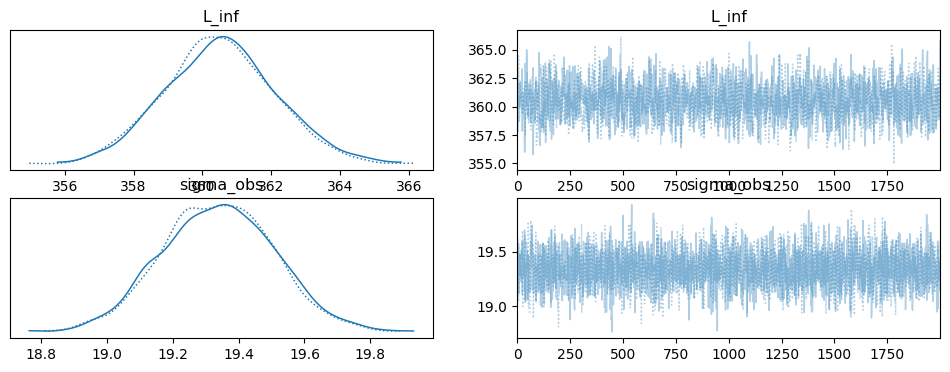

In [38]:
az.plot_trace(trace_vbgm, var_names=["L_inf", "sigma_obs"])
az.summary(trace_vbgm, var_names=["L_inf", "sigma_obs"]).round(3)

## VBGM Energy Plot

<Axes: >

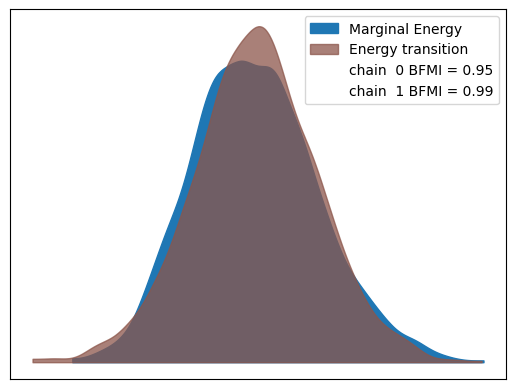

In [39]:
az.plot_energy(trace)

## VBGM Prediction

In [40]:
# Test data
dt_test = X_test["Time at Large"].values.astype(np.float64)
L1_test = X_test["L1"].values.astype(np.float64)
L2_actual = y_test.values.astype(np.float64)

# Posterior means
L_inf_post = trace_vbgm.posterior["L_inf"].mean().item()
k_post = trace_vbgm.posterior["k"].mean().item()

# Predict
L2_pred_vbgm = L_inf_post - (L_inf_post - L1_test) * np.exp(-k_post * dt_test)


## VBGMF Metrics

In [41]:
# Use your unified metrics function
vbgm_metrics = get_model_metrics(
    y_true=L2_actual,
    y_pred=L2_pred_vbgm,
    k_params=3,  # L_inf, k, sigma_obs
    model_name="Traditional VBGM"
)

highlight_df = pd.concat([highlight_df, vbgm_metrics])
highlight_df



,RMSE,MAE,R2,AIC,AICC,BIC
Bayesian OLS,24.432,16.815,0.920,18877.947,18879.254,19135.352
Random Forest,17.028,11.140,0.961,16754.876,16756.183,17012.281
XGBoost,18.508,12.211,0.954,17244.966,17246.273,17502.371
LightGBM,16.182,10.649,0.965,16455.149,16456.456,16712.554
NN,16.846,11.108,0.962,124639.948,NaN,447994.615
SVR,16.145,10.676,0.965,16361.878,16361.886,16379.836
KNN,19821.219,18558.452,-52781.523,58185.709,58185.717,58203.667
Traditional VBGM,20.330,14.468,0.944,17717.166,17717.174,17735.125


# Bayesian Gompertz Model

## GM Estimation

In [42]:
import pymc as pm
import arviz as az
import numpy as np

# Core Gompertz inputs
dt = X_train["Time at Large"].values.astype(np.float64)
L1 = X_train["L1"].values.astype(np.float64)
L2 = y_train.values.astype(np.float64)  # Forklength at Recapture

with pm.Model() as gompertz_model:
    # Data containers
    dt_data = pm.MutableData("dt", dt)
    L1_data = pm.MutableData("L1", L1)

    # Priors
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=2)
    sigma_Linf = pm.HalfNormal("sigma_Linf", sigma=2)
    L_inf = pm.Normal("L_inf", mu=40, sigma=10)
    k = pm.HalfNormal("k", sigma=1)
    t0 = pm.Normal("t0", mu=0, sigma=2)

    # Gompertz prediction
    L2_hat = L_inf * pm.math.exp(-pm.math.exp(-k * (dt_data - t0)))

    # Likelihood
    obs = pm.Normal("obs", mu=L2_hat, sigma=sigma_obs, observed=L2)

    # Sampling
    trace_gomp = pm.sample(
        draws=2000,
        tune=1000,
        target_accept=0.9,
        cores=2,
        chains=2,
        return_inferencedata=True
    )


Output()

## GM Posterior Diagnostics

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L_inf,297.056,2.486,292.368,301.789,0.054,0.045,2105.0,2169.0,1.0
sigma_obs,67.428,0.506,66.464,68.366,0.009,0.009,3475.0,2476.0,1.0


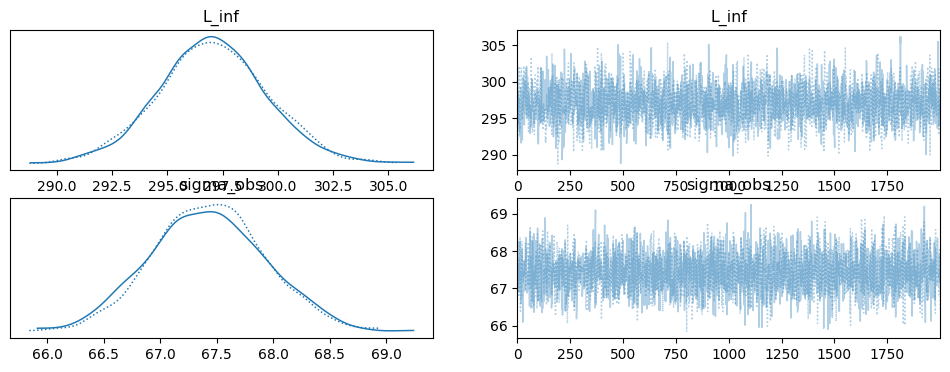

In [43]:
az.plot_trace(trace_gomp, var_names=["L_inf", "sigma_obs"])
az.summary(trace_gomp, var_names=["L_inf", "sigma_obs"]).round(3)

## GM Energy Plot

<Axes: >

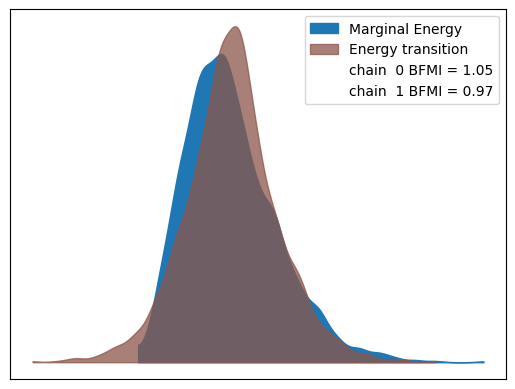

In [44]:
az.plot_energy(trace_gomp)

## GM Prediction

In [45]:
# Prepare test set
dt_test = X_test["Time at Large"].values.astype(np.float64)
L1_test = X_test["L1"].values.astype(np.float64)
L2_actual = y_test.values.astype(np.float64)

# Posterior means
L_inf_post = trace_gomp.posterior["L_inf"].mean().item()
k_post = trace_gomp.posterior["k"].mean().item()
t0_post = trace_gomp.posterior["t0"].mean().item()

# Gompertz prediction
L2_pred_gompertz = L_inf_post * np.exp(-np.exp(-k_post * (dt_test - t0_post)))



## GM Metrics

In [46]:
# Use your standardized metrics function
gompertz_metrics = get_model_metrics(
    y_true=L2_actual,
    y_pred=L2_pred_gompertz,
    k_params=4,  # L_inf, k, t0, sigma_obs
    model_name="Traditional Gompertz"
)

highlight_df = pd.concat([highlight_df, gompertz_metrics])
highlight_df


,RMSE,MAE,R2,AIC,AICC,BIC
Bayesian OLS,24.432,16.815,0.920,18877.947,18879.254,19135.352
Random Forest,17.028,11.140,0.961,16754.876,16756.183,17012.281
XGBoost,18.508,12.211,0.954,17244.966,17246.273,17502.371
LightGBM,16.182,10.649,0.965,16455.149,16456.456,16712.554
NN,16.846,11.108,0.962,124639.948,NaN,447994.615
SVR,16.145,10.676,0.965,16361.878,16361.886,16379.836
KNN,19821.219,18558.452,-52781.523,58185.709,58185.717,58203.667
Traditional VBGM,20.330,14.468,0.944,17717.166,17717.174,17735.125
Traditional Gompertz,71.968,59.590,0.304,25152.221,25152.234,25176.165


# Curves

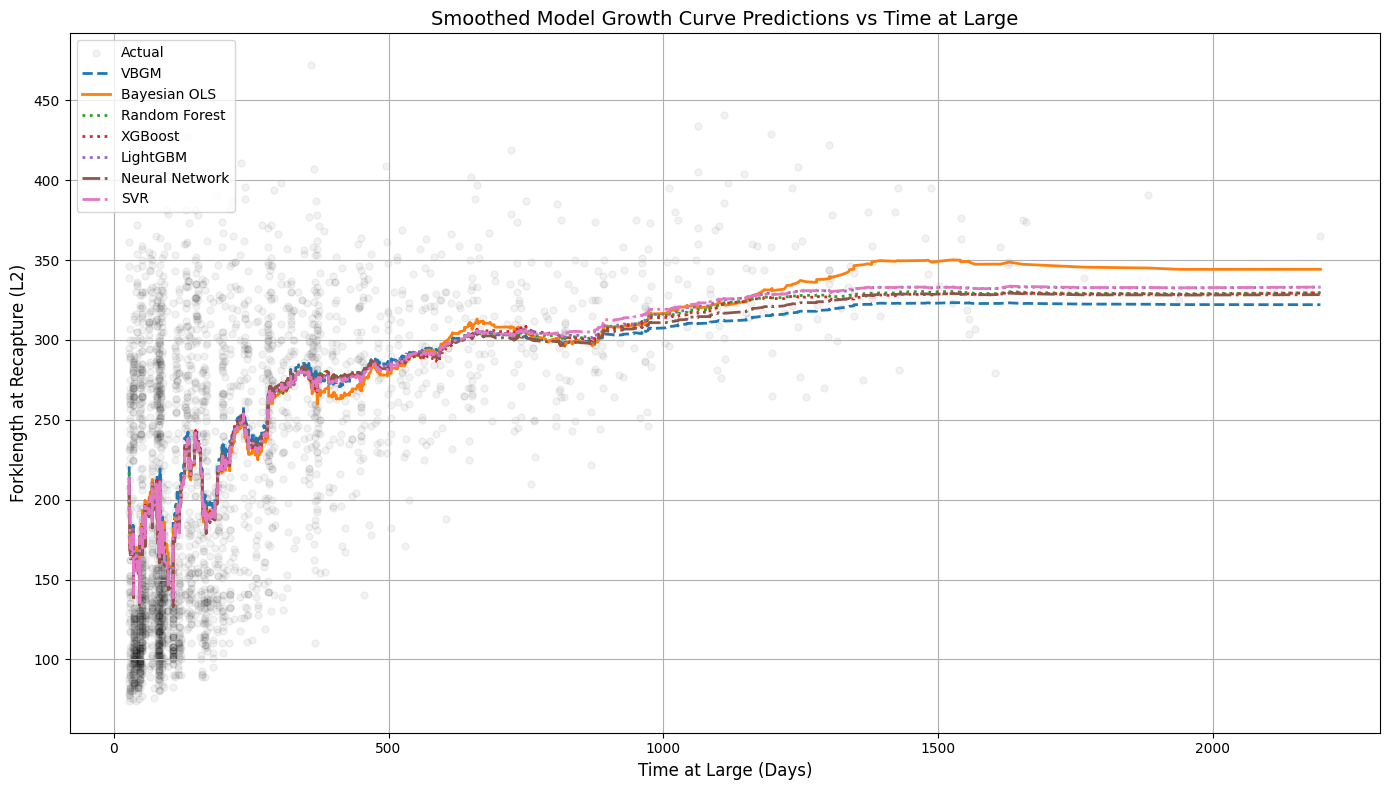

In [47]:
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
import numpy as np

# === Step 1: Sort Time at Large and apply to all variables ===
sorted_indices = np.argsort(dt_test)
dt_sorted = dt_test[sorted_indices]
L2_actual_sorted = L2_actual[sorted_indices]

# === Apply sorting to predictions ===
L2_pred_vbgm_sorted = L2_pred_vbgm[sorted_indices]
L2_pred_gompertz_sorted = L2_pred_gompertz[sorted_indices]
L2_pred_bayesols_sorted = L2_pred_ols[sorted_indices]
L2_pred_randomforest_sorted = L2_pred_randomforest[sorted_indices]
L2_pred_xgboost_sorted = L2_pred_xgboost[sorted_indices]
L2_pred_lightgbm_sorted = L2_pred_lightgbm[sorted_indices]
L2_pred_nn_sorted = L2_pred_nn[sorted_indices]
L2_pred_svr_sorted = L2_pred_svr[sorted_indices]



# === Smoothing for tree-based and SVR models ===
L2_pred_randomforest_smooth = uniform_filter1d(L2_pred_randomforest_sorted, size=100)
L2_pred_xgboost_smooth = uniform_filter1d(L2_pred_xgboost_sorted, size=100)
L2_pred_lightgbm_smooth = uniform_filter1d(L2_pred_lightgbm_sorted, size=100)
L2_pred_svr_smooth = uniform_filter1d(L2_pred_svr_sorted, size=100)


# Adjust smoothing kernel size for noisy models
L2_pred_bayesols_smooth = uniform_filter1d(L2_pred_bayesols_sorted, size=100)
L2_pred_nn_smooth = uniform_filter1d(L2_pred_nn_sorted, size=100)
L2_pred_vgbm_smooth = uniform_filter1d(L2_pred_vbgm_sorted, size=100)

# === Step 2: Plot ===
plt.figure(figsize=(14, 8))

# Actual data points
plt.scatter(dt_sorted, L2_actual_sorted, color='black', alpha=0.05, label="Actual", s=25)

# Model growth curves
plt.plot(dt_sorted, L2_pred_vgbm_smooth, label="VBGM", linestyle="--", linewidth=2)
#plt.plot(dt_sorted, L2_pred_gompertz_sorted, label="Gompertz", linestyle="--", linewidth=2)
plt.plot(dt_sorted, L2_pred_bayesols_smooth, label="Bayesian OLS", linestyle="-", linewidth=2)
plt.plot(dt_sorted, L2_pred_randomforest_smooth, label="Random Forest", linestyle=":", linewidth=2)
plt.plot(dt_sorted, L2_pred_xgboost_smooth, label="XGBoost", linestyle=":", linewidth=2)
plt.plot(dt_sorted, L2_pred_lightgbm_smooth, label="LightGBM", linestyle=":", linewidth=2)
plt.plot(dt_sorted, L2_pred_nn_smooth, label="Neural Network", linestyle="-.", linewidth=2)
plt.plot(dt_sorted, L2_pred_svr_smooth, label="SVR", linestyle="dashdot", linewidth=2)

# Plot decorations
plt.title("Smoothed Model Growth Curve Predictions vs Time at Large", fontsize=14)
plt.xlabel("Time at Large (Days)", fontsize=12)
plt.ylabel("Forklength at Recapture (L2)", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature Importance / Standardized Coefficients /



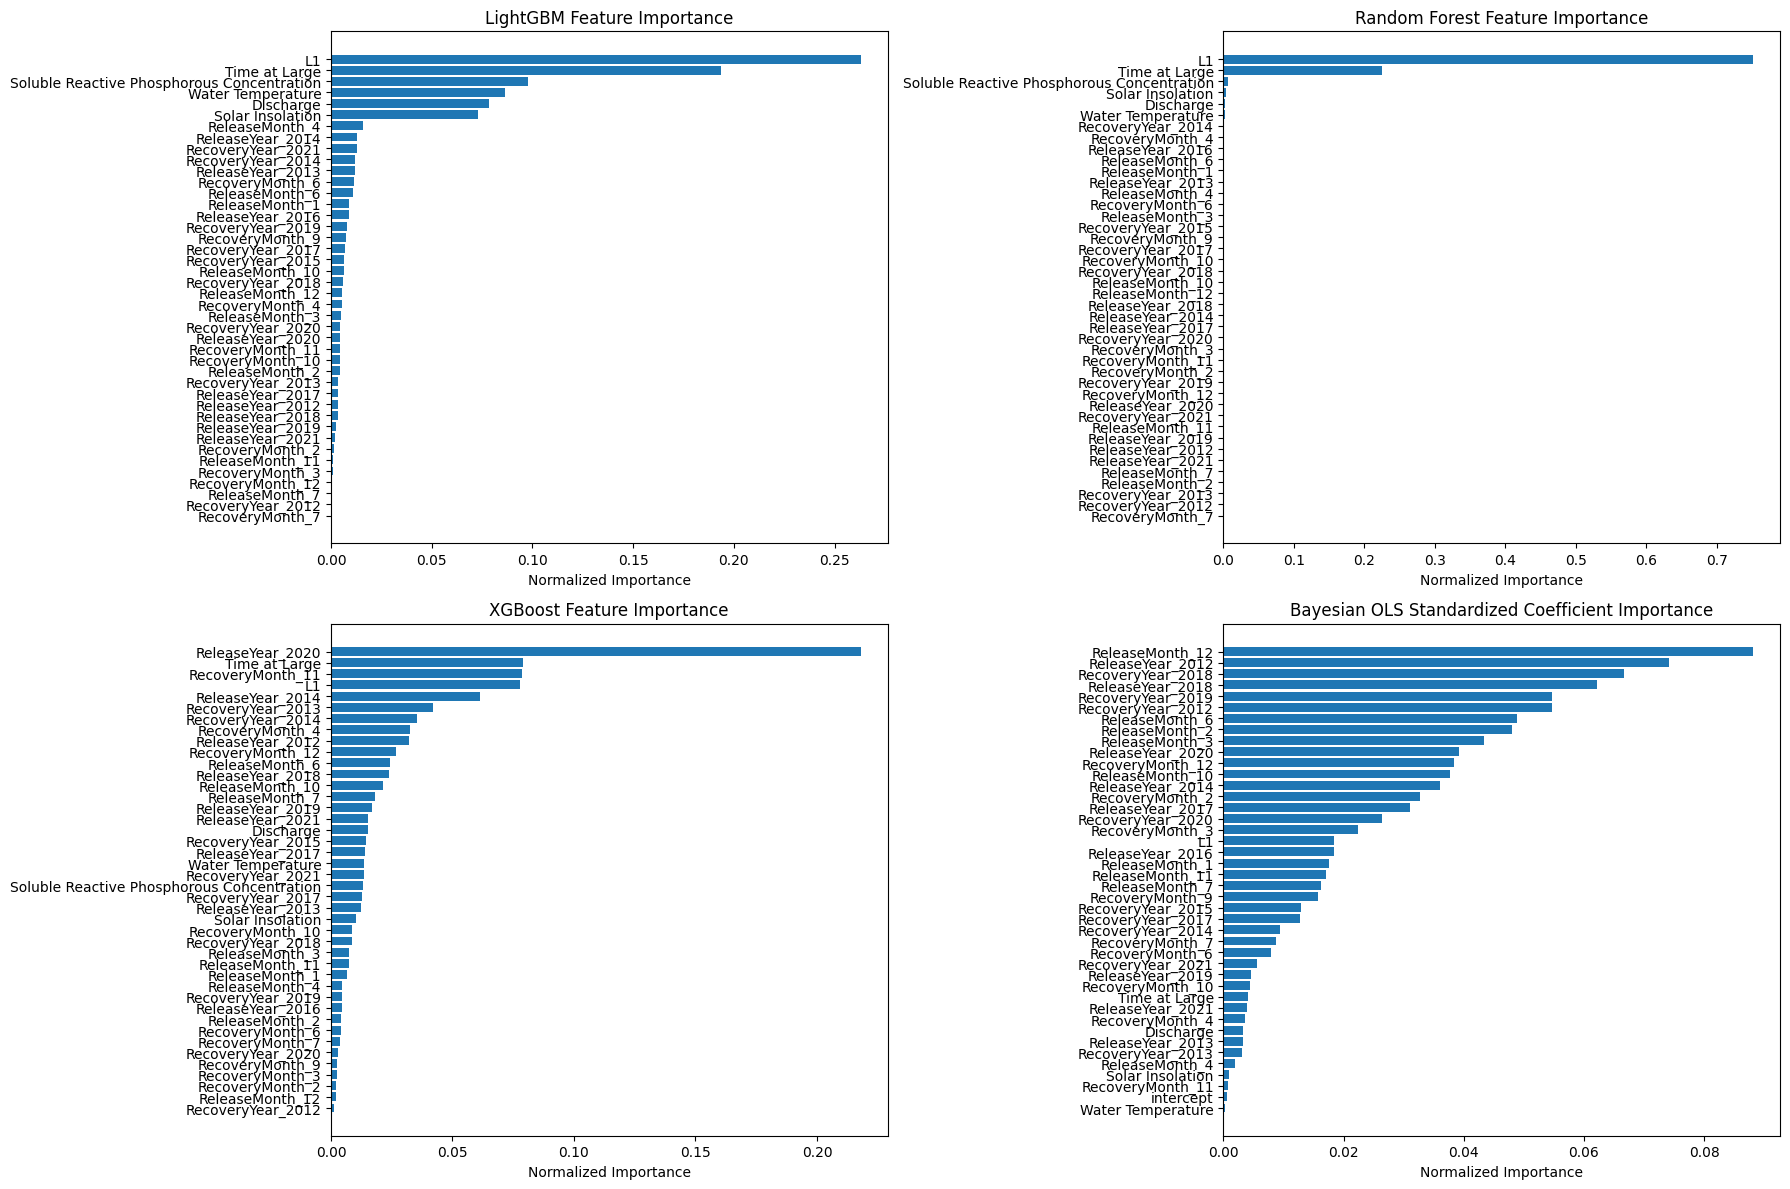

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Standardize X and y for OLS
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_std = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns)
y_train_std = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()


# Pull posterior mean of coefficients from Bayesian trace
bayes_ols_means = trace.posterior["beta"].mean(dim=["chain", "draw"]).values

# Optional: take absolute value for interpretability
ols_std_coefs = np.abs(bayes_ols_means[1:])  # exclude intercept
ols_features = feature_names  # already matches beta ordering (after intercept)

# Get feature names
feature_names = X_train.columns.tolist()

# Collect feature importances
lgb_importances = models["LightGBM"].feature_importances_
rf_importances = models["Random Forest"].feature_importances_
xgb_importances = models["XGBoost"].feature_importances_

# Normalize for comparison
def normalize(v):
    return v / np.sum(v)

lgb_norm = normalize(lgb_importances)
rf_norm = normalize(rf_importances)
xgb_norm = normalize(xgb_importances)
ols_norm = normalize(ols_std_coefs)

# Set up 2x2 plot grid
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
axs = axs.flatten()

def plot_importance(ax, importances, features, title):
    sorted_idx = np.argsort(importances)
    ax.barh(np.array(features)[sorted_idx], importances[sorted_idx])
    ax.set_title(title)
    ax.set_xlabel("Normalized Importance")

# Plot each model
plot_importance(axs[0], lgb_norm, feature_names, "LightGBM Feature Importance")
plot_importance(axs[1], rf_norm, feature_names, "Random Forest Feature Importance")
plot_importance(axs[2], xgb_norm, feature_names, "XGBoost Feature Importance")
plot_importance(axs[3], ols_norm, ols_features, "Bayesian OLS Standardized Coefficient Importance")

plt.tight_layout()
plt.show()


# Hyperparameter Runs (Converted to Markdown)

from sklearn.model_selection import GridSearchCV


## Hyperparameter Tuning, RF
rf = RandomForestRegressor(random_state=42)

## Define the parameter distribution
param_grid = {
    'n_estimators': [100, 150, 200],       # Number of trees
    'max_depth': [5, 10, 15],          # Depth of trees
    'bootstrap': [True, False]             # Bootstrapping options
}

## Initialize model
rf = RandomForestRegressor(random_state=42)

## Define grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=2,
    verbose=2,
    n_jobs=-1
)

## Fit grid search
grid_search.fit(X_train, y_train)

## Get best model
best_rf_model = grid_search.best_estimator_
print("Best Parameters:\n", grid_search.best_params_)


## Hyperparameter Tuning, LGBM

param_grid_lgbm = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

# Initialize model
lgbm = LGBMRegressor(random_state=42)

# Set up grid search
grid_search_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid_lgbm,
    scoring='neg_mean_squared_error',
    cv=2,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search
grid_search_lgbm.fit(X_train, y_train)

## Get best model
best_lgbm_model = grid_search_lgbm.best_estimator_
print("Best Parameters:\n", grid_search_lgbm.best_params_)



## Hyperparameter Tuning, XGBoost
param_grid_xgb = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Initialize model
xgb_model = XGBRegressor(random_state=42, verbosity=0)

# Grid search
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=2,
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search_xgb.fit(X_train, y_train)

## Get best model
best_lgbm_model = grid_search_xgb.best_estimator_
print("Best Parameters:\n", grid_search_xgb.best_params_)



## Hyperparameter Tuning, KNN

from sklearn.model_selection import GridSearchCV

# Define the model and parameter grid
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': list(range(1, 31))}

# Set up grid search with 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit on training data
grid_search.fit(X_train_scaled, y_train_scaled)

# Best K
best_k = grid_search.best_params_['n_neighbors']
print(f"Optimal K: {best_k}")

# Best model
best_knn_model = grid_search.best_estimator_


## Hyperparameter Tuning, SVR

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

## Hyperparameter Tuning, SVR
svr = SVR()

# Simplified parameter grid for faster initial tuning
param_grid = [
    {
        'kernel': ['linear'],
        'C': [1, 10],
        'epsilon': [0.01, 0.1, 0.5]
    },
    {
        'kernel': ['rbf'],
        'C': [1, 10],
        'gamma': ['scale', 0.1],
        'epsilon': [0.01, 0.1, 0.5]
    },
    {
        'kernel': ['poly'],
        'C': [1],
        'degree': [2, 3],
        'gamma': ['scale'],
        'coef0': [0],
        'epsilon': [0.01, 0.1, 0.5]
    }
]

# Set up grid search with 2-fold cross-validation for faster runtime
grid_search = GridSearchCV(
    svr,
    param_grid,
    cv=2,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train_scaled, y_train_scaled)

# Retrieve best model and parameters
best_svr_model = grid_search.best_estimator_
print(f"Best SVR Parameters: {grid_search.best_params_}")
